In [1]:
from bert_serving.client import BertClient
import numpy as np
import pandas as pd
import nltk
Porter = nltk.stem.PorterStemmer()
import csv
import pickle
import re
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import spatial
import pickle

In [2]:
def readfile(filename,method='utf-8'):
    rawlist = []
    with open(filename,'r+', encoding=method) as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            rawlist.append(row)
    return rawlist

def writefile(filename,inputlist,method='utf-8'):
    with open(filename,'a+', encoding=method) as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for row in inputlist:
            writer.writerow(row)
            
def regex(a):
    reg = []
    #a = re.sub('[a-zA-Z]','',a)
    a = re.sub('[,、：；！？，。－"\']','#',a)
    a = re.sub('[「」(){}:;!?]','',a)
    a = re.sub('\n','',a)
    #a = re.sub('[(),{}\u3000\*\|=-\[\]\n.]','',a)
    #a = re.sub(u"\\（.*?\\）|\\『.*?』|\\「.*?」|\\〔.*?〕|\\[.*?]|\\〈.*?〉", '', a)
    reg = a.split('#')
    return reg

def en_regex(a):
    #a = re.sub('[a-zA-Z]','',a)
    a = re.sub('[(){}.:,;!?：；！？，。－"\']','',a)
    #a = re.sub(',',' ',a)
    #a = re.sub('\n','',a)
    #a = re.sub('[(),{}\u3000\*\|=-\[\]\n.]','',a)
    #a = re.sub(u"\\（.*?\\）|\\『.*?』|\\「.*?」|\\〔.*?〕|\\[.*?]|\\〈.*?〉", '', a)
    if not a.find('to ')==-1:
        a = a[a.find('to ')+3:]
    return a

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [198]:
bc = BertClient()

In [3]:
adictsrc = readfile('zh_en_dict.csv')
adict = dict()
for i in range(0,len(adictsrc)):
    adict[adictsrc[i][0]] = adictsrc[i][1:]
len(adict)

114442

In [4]:
with open('bertvectors1.pickle', 'rb') as file:
    tmpd1 = pickle.load(file)
with open('bertvectors2.pickle', 'rb') as file:
    tmpd2 = pickle.load(file)
with open('bertvectors3.pickle', 'rb') as file:
    tmpd3 = pickle.load(file)
with open('bertvectors4.pickle', 'rb') as file:
    tmpd4 = pickle.load(file)
bertvectors = {**tmpd1, **tmpd2, **tmpd3, **tmpd4}

In [5]:
with open('chinese_bertvectors.pickle', 'rb') as file:
    chinese_bertvectors = pickle.load(file)

In [6]:
chcut = []
with (open('chcut.pickle', "rb")) as openfile:
    chcut = pickle.load(openfile)
encut = []
with (open('encut.pickle', "rb")) as openfile:
    encut = pickle.load(openfile)

In [7]:
with open('chvector.pickle', 'rb') as file:
    chvector = pickle.load(file)
with open('envector.pickle', 'rb') as file:
    envector = pickle.load(file)

In [8]:
ch_dic = []
for i in range(0,len(chcut)):
    for j in range(0,len(chcut[i])):
        for word in chcut[i][j]:
            if word not in ch_dic:
                ch_dic.append(word)

In [9]:
pairs = []
for word in ch_dic:
    try:
        means = adict[word]
    except:
        continue
    if len(means)==1 and isEnglish(means[0]) and len(means[0])>=2:
        tmp = en_regex(means[0]).strip()
        if not len(tmp.split())>3 and not len(tmp)>20:
            pairs.append([word,tmp])

In [10]:
chinese_numbers = ['一','二','三','四','五','六','七','八','九']
pairs = sorted(pairs)
for line in pairs:
    if line[0] in chinese_numbers:
        print(line)

['七', 'seven']
['三', 'three']
['九', 'nine']
['五', 'five']
['八', 'eight']
['六', 'six']
['四', 'four']


In [11]:
pairvector = []
for i in range(0,len(pairs)):
    if not pairs[i][1] == '':
        ch = chvector[pairs[i][0]]
        en = envector[pairs[i][1]]
        #en = bc.encode([pairs[i][1]])
    pairvector.append([ch,en,pairs[i][0],pairs[i][1]])

In [12]:
chcombined = pairvector[0][0]
encombined = pairvector[0][1]
for i in range(1,len(pairvector)):
    chcombined = np.append(chcombined,pairvector[i][0],axis=0)
print(type(chcombined[1]))
for i in range(1,len(pairvector)):
    encombined = np.append(encombined,pairvector[i][1],axis=0)
print(type(encombined[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [13]:
def cal_cost(theta,X,y,method='MSE'):
    m = len(y)
    cost = 0
  
    if method == 'ED':
        #eucilidean distance
        for i in range(m):
            cost = cost + np.sqrt(np.sum(np.square(np.dot(X[i],theta) - y[i])))
            #print(cost)
        #print('XXX')
        cost = 1/(2*m)*cost
    else:
        y_pred = []
        for i in range(m):
            y_pred.append(np.dot(X[i],theta))
        mse = mean_squared_error(y, y_pred)
        cost = np.sum(mse)
    return cost

In [17]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100,how='MSE'):
    m = len(y)
    print('訓練資料組數 =',m)
    cost_history = np.zeros(iterations)
    #theta_history = np.zeros((iterations,768,768))
    for it in range(iterations):
        prediction = np.dot(X,theta)
        result = prediction-y
        theta = theta - (1/m)*learning_rate*(np.dot(X.T,result))   
        #theta_history[it,:] = theta.T
        cost_history[it]  = cal_cost(theta,X,y,method=how)
        if it%100==0:
            print(it,cost_history[it])
    #return theta, cost_history, theta_history
    return theta, cost_history

In [19]:
#theta = np.random.randn(768,768)
theta = np.zeros((768,768))
head = random.randint(0,852)
tail = head+1000
print(head,tail)
trans_matrix, cost_history = gradient_descent(chcombined[:],encombined[:],theta,0.001,10000)
ED_matrix, ED_cost_history = gradient_descent(chcombined[:],encombined[:],theta,0.001,10000,how='ED')

337 1337
訓練資料組數 = 1851
0 0.1387494865192668
100 0.02459579173949868
200 0.02301504288052404
300 0.021949721314099047
400 0.021177039636430972
500 0.02057977701712758
600 0.02009411444768164
700 0.01968388519145352
800 0.019327638870225598
900 0.019012008871887028
1000 0.01872823119558387
1100 0.018470268361501733
1200 0.018233768028893305
1300 0.018015465871725412
1400 0.0178128309801609
1500 0.017623847349453856
1600 0.017446874011684165
1700 0.0172805520516058
1800 0.01712374049658781
1900 0.016975470591823725
2000 0.016834912180512824
2100 0.016701348319190044
2200 0.016574155672542112
2300 0.016452789082441664
2400 0.016336769230463146
2500 0.01622567264521586
2600 0.016119123521699568
2700 0.01601678696399939
2800 0.015918363361393958
2900 0.015823583677356524
3000 0.01573220548087548
3100 0.015644009586253938
3200 0.015558797195094884
3300 0.015476387455192869
3400 0.015396615367323854
3500 0.015319329983683483
3600 0.015244392851837263
3700 0.015171676666136058
3800 0.0151010640

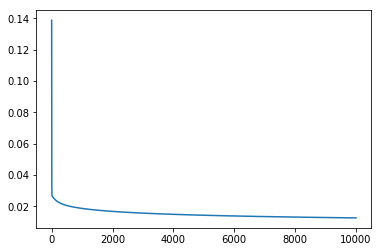

In [20]:
plt.plot(cost_history)

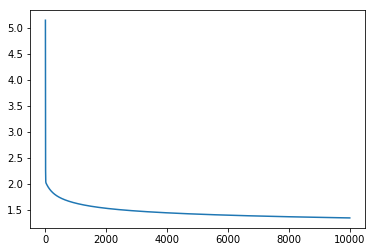

In [21]:
plt.plot(ED_cost_history)

In [22]:
#Best For Now
trans_matrix100, cost_history100 = gradient_descent(chcombined[:100],encombined[:100],theta,0.001,5000)

訓練資料組數 = 100
0 0.14824163880978816
100 0.03208952110824549
200 0.025972469878738105
300 0.021994740958323822
400 0.019170791170607885
500 0.017046917116236186
600 0.015383211858019363
700 0.014039019560778613
800 0.012925839863458409
900 0.011985190244963173
1000 0.011176976675563869
1100 0.010472872638330175
1200 0.009852335061247504
1300 0.009300111160036916
1400 0.008804630891554437
1500 0.008356944437567944
1600 0.007950004424638992
1700 0.007578171225387019
1800 0.007236865558076742
1900 0.006922320162049705
2000 0.006631399279950352
2100 0.006361465316907359
2200 0.0061102788434745535
2300 0.005875922522671574
2400 0.00565674245176762
2500 0.005451302356621803
2600 0.005258347397386172
2700 0.005076775252580905
2800 0.004905612781013195
2900 0.004743997006928422
3000 0.0045911594919496755
3100 0.004446413387008713
3200 0.004309142625081207
3300 0.004178792839191794
3400 0.00405486368232865
3500 0.00393690229530647
3600 0.003824497721373087
3700 0.0037172761068316913
3800 0.003614

In [63]:
chinese_numbers = ['四','五','六','七','八','九']
chinese_name = ['4','5','6','7','8','9']

target_vector = ['紅色','綠色','藍色','黃色','紫色','白色','黑色','橙色']
target_vectorname = ['red','green','blue','yellow','purple','white','black','orange']


target_vector = ['四','五','六','七','八','九']
target_vectorname = ['4','5','6','7','8','9']

#target_vector = ['我','你','他','它']
target_vector2 = ['今天','明天','後天','昨天']

chinese_numbers = ['中國','臺灣','掃描','病毒','伺服器','綠色','公里','太陽能']
chinese_numbers = ['四','五','六','七','八','九']


In [64]:
pre = []
pairs = sorted(pairs)
print("%s       %s   %4s  %8s %4s" % ('ch','en','init','baseline','exp'))
print('--------------------------------------')
for line in pairvector:
    if line[2] in chinese_numbers:
        #print(line[2])
        pre2 = np.dot(line[0],trans_matrix100)
        pre = np.dot(line[0],trans_matrix)
        originalstat = 1-spatial.distance.cosine(line[0],line[1])
        teststat2 = 1-spatial.distance.cosine(pre2,line[1])
        teststat = 1-spatial.distance.cosine(pre,line[1])
        print("%s %12s %.4f %.4f %.4f" % (line[2],line[3],originalstat,teststat2,teststat))
        #print(line[2],line[3],originalstat,teststat)


ch       en   init  baseline  exp
--------------------------------------
七        seven 0.0644 0.9589 0.9822
九         nine 0.0806 0.9545 0.9779
五         five 0.0237 0.9592 0.8153
八        eight 0.0233 0.8709 0.8391
六          six 0.0708 0.9347 0.9822
四         four 0.0237 0.9390 0.8603


In [55]:
def draw_scatter_plot(Df,tag,col='yellow'):
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(Df['component 1'], Df['component 2'])
    for label, x, y in zip(tag,Df['component 1'],Df['component 2']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc=col, alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.show()

In [56]:
def scatter_plot_experiment(pairvector,target,tag,trans_matrix):
    pca = PCA(n_components=2)
    ev = np.zeros([1,768])
    cv = np.zeros([1,768])
    for line in pairvector:
        if line[2] in target:
            ev = np.append(ev,line[1],axis=0)
            cv = np.append(cv,np.dot(line[0],trans_matrix),axis=0)
    ev = np.delete(ev,1,0)
    cv = np.delete(cv,1,0)
    evpca = pca.fit_transform(ev)
    cvpca = pca.fit_transform(cv)
    #evpca = preprocessing.scale(evpca)
    #cvpca = preprocessing.scale(cvpca)
    evDf = pd.DataFrame(data = evpca,columns = ['component 1', 'component 2'])
    cvDf = pd.DataFrame(data = cvpca,columns = ['component 1', 'component 2'])
    draw_scatter_plot(evDf,tag)
    draw_scatter_plot(cvDf,tag,'blue')

In [57]:
def precision_at_5_experiment(target,pairvector,trans_matrix):
    pca = PCA(n_components=2)
    cv = []
    output = []
    noutput = []
    for word in target:
        for i in range(0,len(pairvector)):
            if word == pairvector[i][2]:
                vec = chinese_bertvectors[word]
                cv.append(np.dot(vec,trans_matrix))
                break
        
    for i in range(0,len(cv)):
        for j in range(0,len(pairvector)): 
            cos = 1-spatial.distance.cosine(cv[i],pairvector[j][1])
            output.append([cos,pairvector[j][3]])
        output = sorted(output,reverse=True)
        for x in range(0,len(output)):
            if not output[x][1] == output[x-1][1]:
                noutput.append(output[x]) 
        print(target[i])
        for x in range(0,5):
            print(noutput[x])
        output = []
        noutput = []

In [58]:
tvec = ['中國','臺灣','你','病毒','伺服器','綠色','公里','太陽能']
#tvec = ['你','公里']
precision_at_5_experiment(tvec,pairvector,trans_matrix)

中國
[0.9576409727894944, 'neutral']
[0.9576409727894944, 'medium']
[0.957310864150016, 'online']
[0.9533720694904487, 'head']
[0.9533720694904487, 'bottom']
臺灣
[0.9799165899756178, 'you']
[0.9799165899756178, 'write characters']
[0.9799165899756178, 'worsen']
[0.9799165899756178, 'worm']
[0.9799165899756178, 'workpiece']
你
[0.9808280773110749, 'zinc']
[0.9808280773110749, 'yttrium']
[0.9808280773110749, 'you informal']
[0.9808280773110749, 'you courteous']
[0.9808280773110749, 'yes']
病毒
[0.9969553184379155, 'you']
[0.9969553184379155, 'write characters']
[0.9969553184379155, 'worsen']
[0.9969553184379155, 'worm']
[0.9969553184379155, 'workpiece']
伺服器
[0.9978773339161058, 'zinc oxide']
[0.9978773339161058, 'worker']
[0.9978773339161058, 'wireless']
[0.9978773339161058, 'volatility']
[0.9978773339161058, 'visualization']
綠色
[0.9908210766298114, 'you']
[0.9908210766298114, 'write characters']
[0.9908210766298114, 'worsen']
[0.9908210766298114, 'worm']
[0.9908210766298114, 'workpiece']
公里
[

In [61]:
cost = 0
for i in range(0,len(pairvector)):
    if pairvector[i][2] in tvec:
        #cost = cost + np.sqrt(np.sum(np.square(np.dot(pairvector[i][0],trans_matrix) - pairvector[i][1])))
        #print(cost)
        tmp = np.dot(pairvector[i][0],trans_matrix)
        print(pairvector[i][2],pairvector[i][3],1-spatial.distance.cosine(tmp,pairvector[i][1]))

中國 China 0.9406519014205574
伺服器 server 0.9978773339161058
公里 kilometer 0.9434222988564286
太陽能 solar energy 0.9313017442379665
掃描 scan 0.9966172146334824
病毒 virus 0.9969553184379155
綠色 green 0.9908210766298114
臺灣 Taiwan 0.9799165899756178


In [434]:
tmp2 = 0
tmp = 0
for i in range(0,len(pairvector)):
    #print(pairvector[i][2])
    if pairvector[i][3] == 'cooling water':
        tmp = pairvector[i][1]
    elif pairvector[i][2] == '台北':
        tmp2 = pairvector[i][1]   
print(1-spatial.distance.cosine(tmp2,tmp))

0.9168239831924438


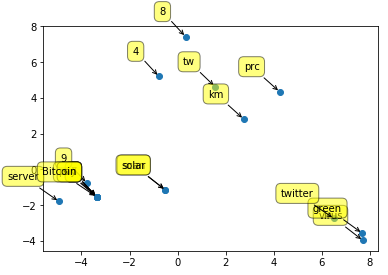

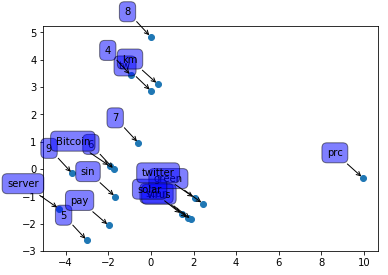

In [62]:
tvec = ['中國','臺灣','掃描','病毒','伺服器','綠色','公里','太陽能','推特','四','五','六','七','八','九','支付','新加坡','比特幣']
tags = ['prc','tw','scan','virus','server','green','km','solar','twitter','4','5','6','7','8','9','pay','sin','Bitcoin']
#tvec = ['頭部','頸','鼻炎','臉部']
#tvec = ['綠色','藍色']
#tags = ['green','blue']
#tags = ['head','neck','ill','face']
scatter_plot_experiment(pairvector,tvec,tags,trans_matrix)

In [36]:
cost_collection = []
theta = np.zeros((768,768))

for i in range(1,10):
    trans_matrix, cost_history, theta_history = gradient_descent(chcombined[:100*i],encombined[:100*i],theta,0.001,1000)
    cost_collection.append(cost_history)

訓練資料組數 = 100
訓練資料組數 = 200
訓練資料組數 = 300
訓練資料組數 = 400
訓練資料組數 = 500
訓練資料組數 = 600
訓練資料組數 = 700
訓練資料組數 = 800
訓練資料組數 = 900


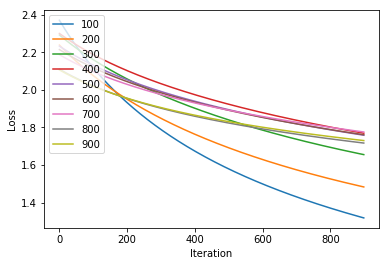

In [66]:
for i in range(0,len(cost_collection)):
    plt.plot(cost_collection[i][100:])
plt.legend(['100', '200', '300', '400', '500', '600','700','800','900'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.show()
#plt.savefig('different_training_pairs.png')
plt.savefig('pairs_diff.png', bbox_inches='tight')

In [23]:
with open('trans_matrix100.pickle', 'wb') as f:
    pickle.dump(trans_matrix100, f)
with open('trans_matrix.pickle', 'wb') as f:
    pickle.dump(trans_matrix, f)
with open('trans_matrixED.pickle', 'wb') as f:
    pickle.dump(ED_matrix, f)